In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress
from glob import glob
from re import split

In [2]:
out_path = '../../data/frequencies/regions/seAsia_compare_params/'
tree_path = '../../data/frequencies/regions/seAsia_compare_params/dengue_all_tree.json'
freqs_paths = glob('../../data/frequencies/regions/seAsia_compare_params/*frequencies.json')
reference_path = '../../data/reference_seqs/genotype_refs_pyke2016.csv'
titer_path = '../../data/katzelnick2015/processed/genotypes_normalized.csv'

In [3]:
def assign_genotype_attr(tree, mrcas):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in ['genotype', 'genotype_mrca', 'clade_name']}
        
    def annotate(genotype, node):
        node.traits['genotype_mrca'] = True
        node.traits['genotype'] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if 'genotype' in child.traits:
                if genotype != child.traits['genotype']:
                    print 'ERROR: Overlapping genotypes %s and %s at index %s'%(child.traits['genotype'], genotype, child.index)
            child.traits['genotype'] = genotype
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, list):
            for node in mrca:
                annotate(genotype, node)
        else:
            annotate(genotype, mrca)

    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    json_translation = {
        'name': 'strain',
        'height': 'xvalue',
    }
    tree = bt.loadJSON(path, json_translation) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits
            and node.traits['clade_name'] != 'DENV2_AMERICAN'}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def annotate_references(tree, path=reference_path):
    refs = pd.read_csv(path, names=['serotype', 'genotype', 'year', 'accession', 'country', 'location'])
    refs['sero_geno'] = refs['serotype']+'_'+refs['genotype']
    ref_map = {acc:geno.upper() for (acc, geno) in zip(refs['accession'], refs['sero_geno'])}
    for k in tree.Objects:
        if k.branchType=='leaf' and k.traits['accession'] in ref_map:
            k.traits['reference_genotype'] = ref_map[k.traits['accession']]
    return tree

def init_genotypes_from_references(tree):
    genotype_refs = defaultdict(list)
    for k in tree.Objects:
        if 'reference_genotype' in k.traits:
            genotype_refs[k.traits['reference_genotype']].append(k)
    genotype_mrcas = { gt: tree.commonAncestor(tips, numName=True) for gt, tips in genotype_refs.items() }
    return genotype_mrcas

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

In [4]:
#### Parse the tree & assign genotypes

tmp = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = tmp['tree']
tree = annotate_references(tree)

# {'DENV2_AMERICAN': <baltic node>}
mrcas = tmp['mrcas']
if mrcas == {}:
    mrcas = init_genotypes_from_references(tree)

# ['denv2_american', 'denv1_I', ...]
genotypes = mrcas.keys()

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)


Tree height: 0.357550
Tree length: 6.132190
annotations present

Numbers of objects in tree: 2998 (1428 nodes and 1570 leaves)



In [5]:
mrcas['DENV1_I'] = 2625
mrcas['DENV1_II'] = 2266
mrcas['DENV1_IV'] = 2274
mrcas['DENV1_V'] = [2163, 2117, 1916, 1894]
mrcas['DENV1_III'] = None

mrcas['DENV3_I'] = 1398
mrcas['DENV3_II'] = 1528
mrcas['DENV3_III'] = 1589
mrcas['DENV3_V'] = 1393

mrcas['DENV4_SYLVATIC'] = 972
mrcas['DENV4_I'] = 976
mrcas['DENV4_II'] = 1086

mrcas['DENV2_AMERICAN'] = 33
mrcas['DENV2_ASIANII'] = 497
mrcas['DENV2_COSMOPOLITAN'] = 117
mrcas['DENV2_ASIANI'] = 543
mrcas['DENV2_SYLVATIC'] = 8
mrcas['DENV2_ASIANAMERICAN'] = 636

def update_mrcas(mrcas=mrcas, tree=tree):
    
    def lookup_node(genotype, clade, tree):
        try:
            return [k for k in tree.nodes if k.traits['clade'] == clade][0]
        except:
            print '%s mrca not found'%(genotype)
            return None
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, int) or mrca == None:
            node = lookup_node(genotype, mrca, tree)
            if node:
                mrcas[genotype] = node
            else:
                del mrcas[genotype]
                
        elif isinstance(mrca, list):
            nodes = [lookup_node(genotype, node, tree) for node in mrca]
            nodes = [n for n in nodes if n != None]
            if nodes != []:
                mrcas[genotype] = nodes
            else:
                print 'No MRCAs found for genotype %s'%genotype
                del mrcas[genotype]
    return mrcas

mrcas = update_mrcas(mrcas, tree)
tree = assign_genotype_attr(tree, mrcas)

DENV1_III mrca not found


In [29]:
# tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype'], numName=True, nexus=True)
# open('./tmp_genotype_annotation.nexus', 'w').write(tree_string)


# ################################
# '''
# Now open tmp_genotype_annotation.nexus in figtree, select:
# appearance > colorby > reference_genotype
# tip labels > reference_genotype
# branch labels > clade

# fill in the clade # for each genotype MRCA below, 
# then run the cell to update the attributes in the tree and pull the correct frequency vectors
# '''
# #################################
# pass

In [6]:
def load_all_frequencies(mrcas, path):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''    
    raw_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = raw_frequencies.pop('pivots') # [1917., 1918., ...]
    
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'0': [0.1, 0.23, ...] } }
    for label, freqs in raw_frequencies.items():
        if 'clade:' not in label: #south_america_II, africa_denv4_II
            split_label = label.split('_')

            if 'DENV' in label:
                region = '_'.join(split_label[:-2])
                clade = '_'.join(split_label[-2:])
            else:
                region = '_'.join(split_label[:-1])
                clade = '_'.join(split_label[-1:])
            try:
                clade = mrcas[clade].traits['clade']
            except:
                continue
                
        else: # 'global_clade:0'
            region, clade = label.split('_clade:')
            
        clade = int(clade) # the tree uses integers for clade indices
        regional_clade_frequencies[region][clade] = freqs 
        
    return {'frequencies': dict(regional_clade_frequencies), 
            'pivots': pivots }

def get_genotype_frequencies(mrcas, frequencies):
    genotype_frequencies = defaultdict(dict)
    
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, bt.node):
            mrca_clade = mrca.traits['clade']
            genotype_frequencies[genotype] = frequencies[mrca_clade] 
            
        elif isinstance(mrca, list):
            mrca_clades = [m.traits['clade'] for m in mrca]
            clade_frequencies = [frequencies[c] for c in mrca_clades]
            total_genotype_frequency = [sum(i) for i in zip(*clade_frequencies)]
            genotype_frequencies[genotype] = total_genotype_frequency
            
    return dict(genotype_frequencies)

def make_dataframe(genotype_frequencies, pivots, mindate=1970.):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    df = pd.DataFrame(genotype_frequencies, index=pivots)
    df = df.loc[df.index[df.index >= mindate]]
    return df

In [7]:
frequencies = {}

for path in freqs_paths:
    fname = path.split('/')[-1].split('_frequencies.json')[0]
    pivots = fname.split('pivots')[1]
    stiffness = fname.split('stiffness')[1].split('_')[0]
    tmp = load_all_frequencies(mrcas, path)    
    freqs = get_genotype_frequencies(mrcas, tmp['frequencies']['southeast_asia']) # {'south_america': {'asianI': []}}

    frequencies[(pivots, stiffness)] = make_dataframe(freqs, tmp['pivots'])

In [8]:
def plot_frequencies(df, ax, date_range = None):
    ax.set_xlabel('Year')
    ax.set_ylabel('Genotype Frequency')

    pivots = df.index.tolist()
    
    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for genotype, freqs in df.iteritems():
        ax.plot(pivots, freqs, color=colors[genotype], label=genotype)   
    
def plot_tree(tree, labels=False):
    branchWidth=2 ## default branch width
    ll = tree

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        c = colors[k.traits['genotype']] if k.traits.has_key('genotype') else 'gray'
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    x0,x1 = plt.xlim()

    plt.xlim((x0, x1*1.1))

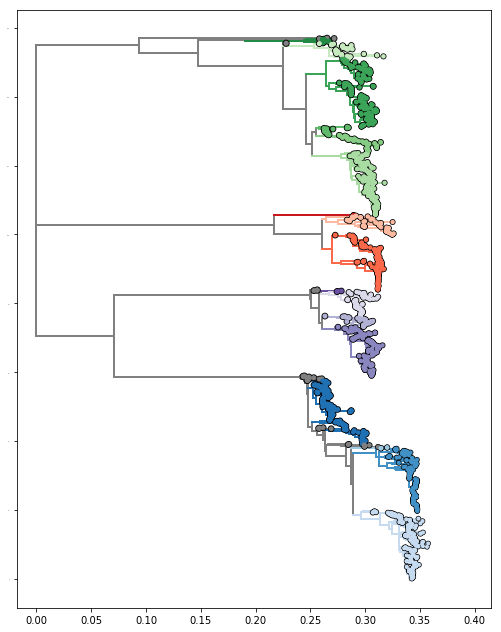

In [9]:
fig, ax = plt.subplots(figsize=(8.5, 11))
plot_tree(tree)

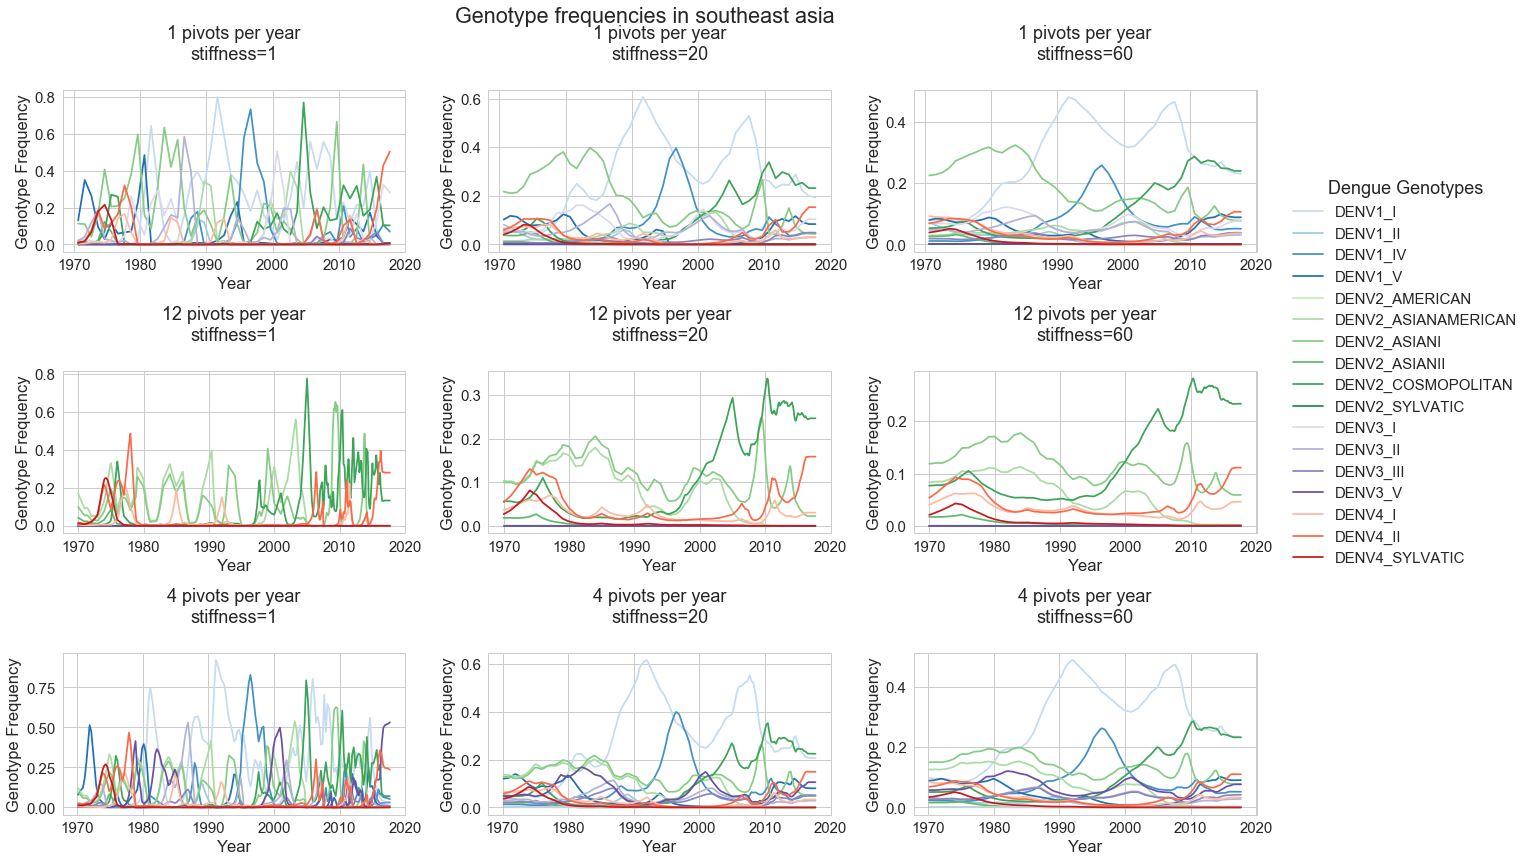

In [10]:
sns.set(style='whitegrid', font_scale=1.5)
fig, axes = plt.subplots(3,3, figsize=(18,12))
axes = axes.flatten()

for params, ax in zip(sorted(frequencies.keys()), axes):
    ax.set_title('%s pivots per year\nstiffness=%s\n '%(params[0], params[1]), va='bottom')
    plot_frequencies(frequencies[params], ax)
    
plt.suptitle('Genotype frequencies in southeast asia', va='bottom')
plt.legend(loc=1,bbox_to_anchor=(1.8, 4), title='Dengue Genotypes')
plt.tight_layout()